In the previous analysis we have seen that our scores are white-noise, so it won't make sense to fit any autoregressive model to them. However, we can be stubborn and do it, in which case we won't expect to see any good results in our modelization.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.linalg import eigh
from scipy.interpolate import BSpline
from sklearn.decomposition import PCA
from scipy.stats import norm
from scipy.stats import shapiro
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
data = pd.read_csv("data_clean.csv").drop(columns=["Unnamed: 0"]).set_index("day_tick")

In [3]:
data = data[data.day != 1]

## Step 1. Set up our data 

Set the first log return of a day equal to NaN

In [4]:
data['log_returns'] = data.groupby('day')['log_returns'].transform(lambda x: x.mask(x.index == x.index[0], 0))

Now we can compute the intraday cumulative log returns

In [5]:
data['cum_log_returns'] = data.groupby('day')['log_returns'].cumsum()

In [6]:
data = data.reset_index()

In [7]:
# Pivot the data to have days as rows and ticks as columns
data_reset = data.reset_index()
data_pivot = data_reset.pivot(index='day', columns='tick', values='cum_log_returns')

# Handle missing values by interpolation
data_pivot = data_pivot.interpolate(axis=1)

# Extract the values and the ticks
Y = data_pivot.values
ticks = data_pivot.columns.values

Split the Data into Training and Testing Sets


In [8]:
# Total number of observations
N = Y.shape[0] 

train_size = 500  # Use the first 500 observations for training (first two years)

# Split the data
Y_train = Y[:train_size, :]
Y_test = Y[train_size:, :]

## Step 2. Setup FDA (on the training set)

In [ ]:
def perform_fpca_bspline(Y, ticks, n_basis=20, p_components=5, degree=3):
    
    n_samples, n_ticks = Y.shape
    domain_range = (ticks[0], ticks[-1])
    
    # Construct B-spline Basis Functions
    # Create a knot vector with appropriate knots
    knots = np.linspace(domain_range[0], domain_range[1], n_basis - degree + 1)
    # Add degree many knots at the boundaries
    knots = np.concatenate((
        np.repeat(domain_range[0], degree),
        knots,
        np.repeat(domain_range[1], degree)
    ))
    # Number of basis functions is len(knots) - (degree + 1)
    n_bases = len(knots) - (degree + 1)
    
    # Create B-spline basis functions
    basis_functions = []
    for i in range(n_bases):
        coef = np.zeros(n_bases)
        coef[i] = 1
        spline = BSpline(t=knots, c=coef, k=degree, extrapolate=False)
        basis_functions.append(spline)
    
    # Evaluate basis functions at ticks to construct matrix P
    P = np.array([basis(ticks) for basis in basis_functions]).T
    
    # Handle any NaN values in P (can occur at boundaries)
    P = np.nan_to_num(P)
    
    # Project Data onto Basis Functions to Obtain Coefficients A
    # Solve the least squares problem Y = A * P^T
    # Transpose Y to match dimensions with P
    A = np.linalg.lstsq(P, Y.T, rcond=None)[0].T
    
    # Estimate μ(t) by averaging the coefficients across samples
    mean_coef = np.mean(A, axis=0)
    
    # Define mean function μ(t) using the basis functions
    def mean_function(t):
        basis_eval = np.array([basis(t) for basis in basis_functions])
        return np.dot(mean_coef, basis_eval)
    
    # Center the Coefficients
    A_centered = A - mean_coef
    
    # Estimate the Covariance Matrix of Coefficients Σ_A
    Sigma_A = np.cov(A_centered, rowvar=False)
    
    # Perform Eigen Decomposition of Σ_A-
    eigenvalues_full, eigenvectors_full = eigh(Sigma_A)

    # Sort eigenvalues and eigenvectors in descending order
    idx = eigenvalues_full.argsort()[::-1]  # To get the indexes of the sorting, instead of actually sorting
    eigenvalues_full = eigenvalues_full[idx]
    eigenvectors_full = eigenvectors_full[:, idx]

    # Calculate the total variance using all eigenvalues
    total_variance = np.sum(eigenvalues_full)

    # Keep only the first p_components
    eigenvalues = eigenvalues_full[:p_components]
    eigenvectors = eigenvectors_full[:, :p_components]
    
    # Construct Eigenfunctions ψ_k(t)
    # Each eigenfunction is a linear combination of basis functions 
    eigenfunctions = []
    for k in range(p_components):
        coef = eigenvectors[:, k]
        # Create the eigenfunction as a callable function
        def eigenfunction(t, coef=coef):
            basis_eval = np.array([basis(t) for basis in basis_functions])
            return np.dot(coef, basis_eval)
        eigenfunctions.append(eigenfunction)
    
    # Compute the Scores ξ_{ik}
    # Scores are projections of centered coefficients in the eigenvectors
    scores = np.dot(A_centered, eigenvectors)
    
    # Variance Decomposition 
    explained_variance_ratio = eigenvalues / total_variance
    
    return {
        'mean_function': mean_function,
        'eigenfunctions': eigenfunctions,
        'scores': scores,
        'explained_variance': eigenvalues,
        'explained_variance_ratio': explained_variance_ratio,
        'basis_functions': basis_functions,
        'coef_matrix': A,
        'eigenvectors': eigenvectors
    }

In [10]:
# Perform FPCA on the training data
results_train = perform_fpca_bspline(Y_train, ticks, n_basis=20, p_components=3, degree=3)

# Extract results
mean_function_train = results_train['mean_function']
eigenfunctions_train = results_train['eigenfunctions']
scores_train = results_train['scores']
eigenvalues_train = results_train['explained_variance']
explained_variance_ratio_train = results_train['explained_variance_ratio']
basis_functions_train = results_train['basis_functions']
A_train = results_train['coef_matrix']

## Step 3. Implement the Functional Time Series model AR(1)

Fit Time-Series Models to the Scores

In [11]:
# Updated Time-Series Modeling of the Scores
from sklearn.linear_model import LinearRegression

# Number of principal components
p_components = scores_train.shape[1]

phi_coefficients = []
intercepts = []
residuals_train = []

for k in range(p_components):
    # Extract the training scores for component k
    xi_train = scores_train[:, k]
    
    # Prepare lagged data
    xi_train_lagged = xi_train[:-1]
    xi_train_current = xi_train[1:]
    
    # Reshape for sklearn
    xi_train_lagged = xi_train_lagged.reshape(-1, 1)
    xi_train_current = xi_train_current.reshape(-1, 1)
    
    # Fit AR(1) model using Linear Regression
    model = LinearRegression()
    model.fit(xi_train_lagged, xi_train_current)
    
    # Store the coefficient phi_k and intercept
    phi_k = model.coef_[0][0]
    intercept_k = model.intercept_[0]
    phi_coefficients.append(phi_k)
    intercepts.append(intercept_k)
    
    # Calculate residuals
    xi_predicted = model.predict(xi_train_lagged)
    residuals = xi_train_current.flatten() - xi_predicted.flatten()
    residuals_train.append(residuals)
    
    print(f"AR(1) model for component {k+1} fitted with phi_{k+1} = {phi_k:.4f}, intercept = {intercept_k:.4f}")


AR(1) model for component 1 fitted with phi_1 = -0.0344, intercept = 0.0001
AR(1) model for component 2 fitted with phi_2 = 0.0033, intercept = -0.0000
AR(1) model for component 3 fitted with phi_3 = 0.0031, intercept = 0.0000


Forecast Future Scores

In [12]:
# Number of steps to forecast
h = Y_test.shape[0]  # Forecast horizon equals the size of the test set

# Initialize array to store forecasted scores
scores_forecast = np.zeros((h, p_components))

# Last known scores from training data
xi_last = scores_train[-1, :]

for k in range(p_components):
    phi_k = phi_coefficients[k]
    intercept_k = intercepts[k]
    xi_n = xi_last[k]
    
    # Forecast future scores
    for i in range(h):
        xi_n = intercept_k + phi_k * xi_n
        scores_forecast[i, k] = xi_n


Reconstruct the Functions for the Test Period

In [13]:
n_test_samples = Y_test.shape[0]
Y_test_reconstructed = np.zeros_like(Y_test)

# Evaluate the mean function at all time points
mean_function_values = np.array([mean_function_train(t) for t in ticks])

# Evaluate eigenfunctions at all time points
eigenfunctions_values = np.array([
    np.array([eigenfunctions_train[k](t) for t in ticks]) for k in range(p_components)
]) 

# Reconstruct each test sample
for i in range(n_test_samples):
    # Start with the mean function
    reconstructed = mean_function_values.copy()
    # Add the contribution of each principal component
    for k in range(p_components):
        reconstructed += scores_forecast[i, k] * eigenfunctions_values[k, :]
    Y_test_reconstructed[i, :] = reconstructed


## Step 4. Evaluate Prediction Performance

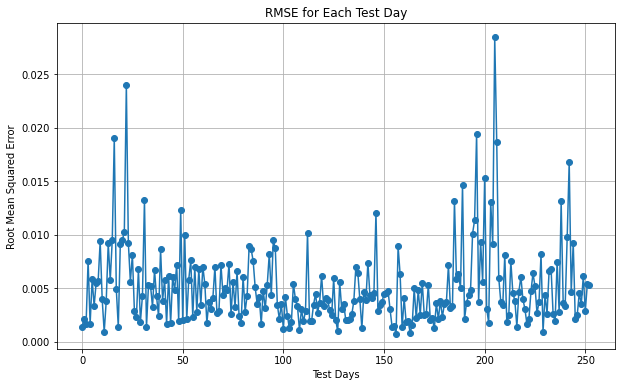

In [14]:
mse_test_samples = np.mean((Y_test - Y_test_reconstructed) ** 2, axis=1)
rmse_test_samples = np.sqrt(mse_test_samples)

# Plot the RMSE for each test day
plt.figure(figsize=(10, 6))
plt.plot(range(n_test_samples), np.sqrt(mse_test_samples), marker='o')
plt.title('RMSE for Each Test Day')
plt.xlabel('Test Days')
plt.ylabel('Root Mean Squared Error')
plt.grid(True)
plt.show()


In [15]:
Y_test.shape

(253, 1440)

In [16]:
Y_test_reconstructed.shape

(253, 1440)

In [17]:
# Compute this error metric between the reconstructed and actual test data
rmse_fpca = np.sqrt(mean_squared_error(Y_test, Y_test_reconstructed))

mu_t = mean_function_train(ticks)

# Create a forecasted Y by repeating the mean function for each test day
Y_forecasted_mean = np.tile(mu_t, (Y_test.shape[0], 1))

# Compute RMSE for Mean Forecast
rmse_mean = np.sqrt(mean_squared_error(Y_test, Y_forecasted_mean))


In [18]:
print(f"RMSE for FPCA-based Forecast: {rmse_fpca:.6f}")
print(f"RMSE for Mean Function Forecast: {rmse_mean:.6f}")

RMSE for FPCA-based Forecast: 0.006315
RMSE for Mean Function Forecast: 0.006315


### We observe how we perform equally with both approaches, which is what we expected

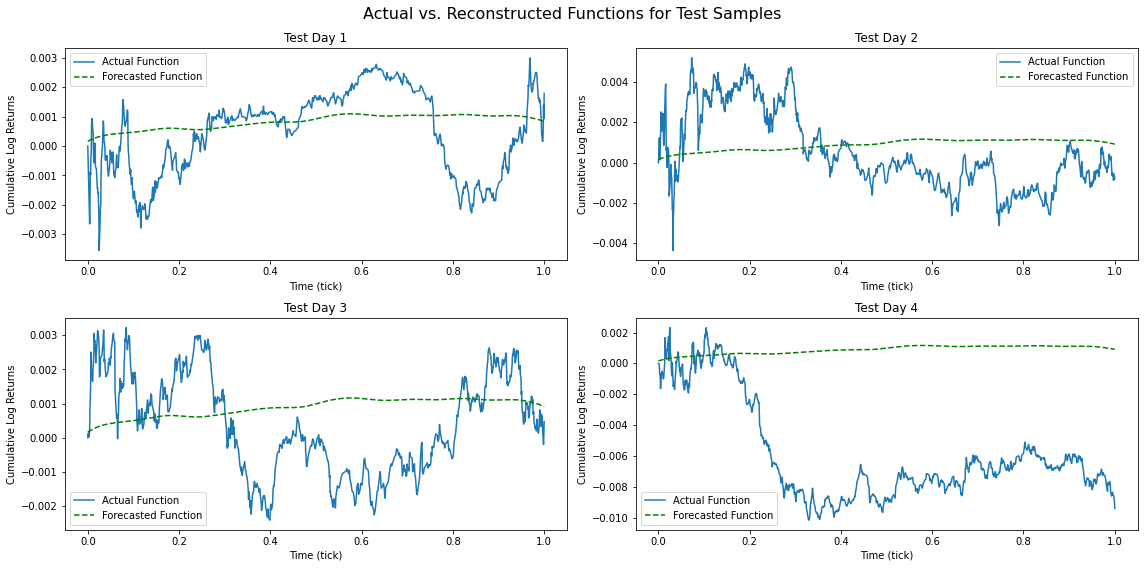

In [19]:
import matplotlib.pyplot as plt

# Number of samples to plot
num_samples_to_plot = 4

rows = 2
cols = 2

fig, axes = plt.subplots(rows, cols, figsize=(16, 8))
fig.suptitle('Actual vs. Reconstructed Functions for Test Samples', fontsize=16)
axes = axes.flatten()

for i in range(num_samples_to_plot):
    ax = axes[i]
    ax.plot(ticks, Y_test[i, :], label='Actual Function')
    ax.plot(ticks, Y_test_reconstructed[i, :], label='Forecasted Function', linestyle='--', color="green")
    ax.set_title(f'Test Day {i+1}')
    ax.set_xlabel('Time (tick)')
    ax.set_ylabel('Cumulative Log Returns')
    ax.legend()

plt.tight_layout()
plt.savefig("FTS.png")


We observe that with out predictions, we haven't done better than just predicting the mean